(10000, 1000)
(10000, 100)
[1.26709807e+00 9.29407403e-02 4.87719417e-01 2.31911707e+00
 3.72719765e+00 3.38396788e+00 1.68824995e+00 2.18568698e-01
 2.83662558e-01 2.38381362e+00 6.43783140e+00 1.20194483e+01
 1.90643368e+01 2.81854458e+01 4.17966003e+01 6.59995728e+01
 1.21319473e+02 3.03816223e+02 1.80237561e+03 1.06647627e+04
 5.81106506e+02 1.94082230e+02 9.56088028e+01 5.38540344e+01
 3.05108929e+01 1.52525988e+01 5.80543566e+00 8.15179229e-01
 2.25874513e-01 2.67810345e+00 5.99719620e+00 7.58468914e+00
 5.98778343e+00 2.42694497e+00 9.46027339e-02 9.09130573e-01
 3.27248406e+00 3.67822862e+00 1.46164608e+00 1.41726516e-03
 1.41017580e+00 2.68111110e+00 1.18474495e+00 1.68385021e-02
 1.46433902e+00 1.83972824e+00 1.81535959e-01 6.56304598e-01
 1.67985427e+00 3.10531199e-01 4.91429508e-01 1.41855288e+00
 1.38719261e-01 7.00783670e-01 1.03535759e+00 3.59276845e-03
 1.05588007e+00 3.32484335e-01 4.37405169e-01 8.22143614e-01
 4.75190058e-02 9.41570640e-01 1.92753207e-02 8.04206133e-

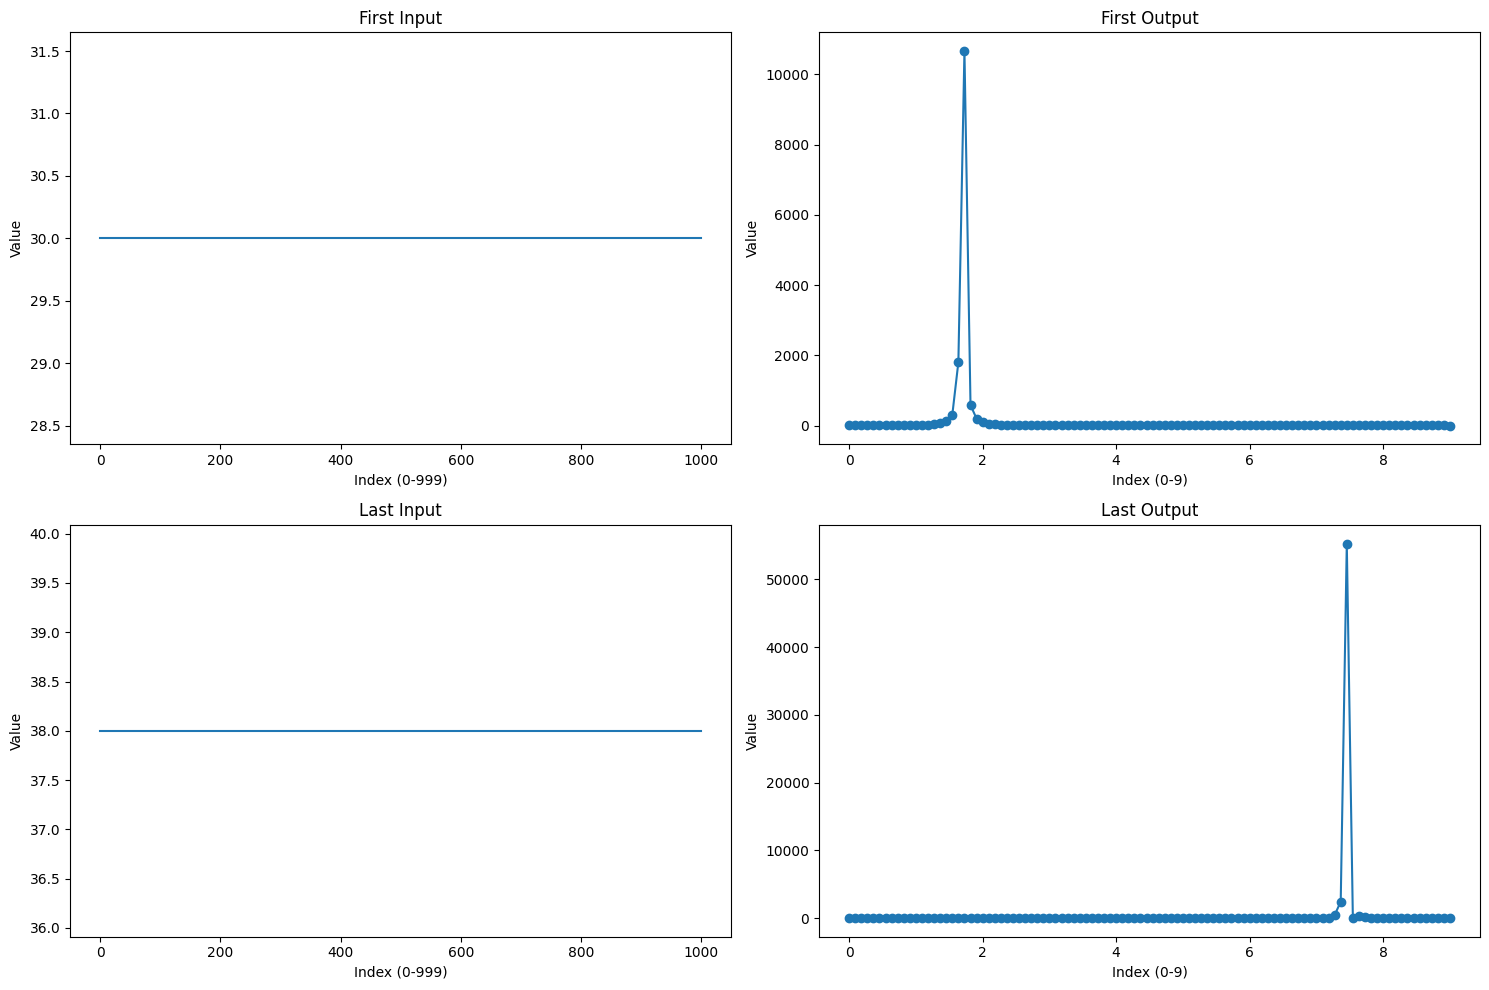

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from syuron import dataset
from workspace import path
import tensorflow as tf

filepath = path.Path("research/syuron/dataset/fixed.tfrecord")
ds = dataset.load(filepath, 50000)
batch = next(iter(ds))
inputs, outputs = batch
print(inputs.shape)
print(outputs.shape)
# tf.data.Dataset.from_tensor_slices((inputs, outputs * 10)).save(
#     path.Path("research/syuron/dataset/chirped_scaled2.tfrecord").abs())

# 最初と最後のデータポイントを取得
first_input = inputs[0]
first_output = outputs[0]
last_input = inputs[-1]
last_output = outputs[-1]

# 横軸を作成
input_x = jnp.linspace(0, 999, 1000)
output_x = jnp.linspace(0, 9, 100)

# プロットを作成
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 最初のinputをプロット
axs[0, 0].plot(input_x, first_input)
axs[0, 0].set_title('First Input')
axs[0, 0].set_xlabel('Index (0-999)')
axs[0, 0].set_ylabel('Value')

# 最初のoutputをプロット
axs[0, 1].plot(output_x, first_output, 'o-')
axs[0, 1].set_title('First Output')
axs[0, 1].set_xlabel('Index (0-9)')
axs[0, 1].set_ylabel('Value')

# 最後のinputをプロット
axs[1, 0].plot(input_x, last_input)
axs[1, 0].set_title('Last Input')
axs[1, 0].set_xlabel('Index (0-999)')
axs[1, 0].set_ylabel('Value')

# 最後のoutputをプロット
axs[1, 1].plot(output_x, last_output, 'o-')
axs[1, 1].set_title('Last Output')
axs[1, 1].set_xlabel('Index (0-9)')
axs[1, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [5]:
from syuron import dataset
from syuron import mgoslt
from syuron import mlp
from workspace import path


filepath = path.Path("research/syuron/dataset/fixed.tfrecord")
ds = dataset.load(filepath)
final_state, final_loss = mgoslt.train_and_eval(
    ds, 10, mlp.OptimizableParams(learning_rate=1e-3, hidden_sizes=[128, 64]))
print("Training completed. Final model loss:")
print(final_loss)

# final_state, final_loss = mgoslt.bayesian_optim_and_eval(ds)

Initial loss: 5479210.0


Epoch 1/10: 100%|██████████| 10/10 [00:00<00:00, 13.12it/s]


Epoch 1: Average Loss = 9250678.0


Epoch 2/10: 100%|██████████| 10/10 [00:00<00:00, 12.84it/s]


Epoch 2: Average Loss = 9235921.0


Epoch 3/10: 100%|██████████| 10/10 [00:00<00:00, 13.06it/s]


Epoch 3: Average Loss = 9215802.0


Epoch 4/10: 100%|██████████| 10/10 [00:00<00:00, 12.82it/s]


Epoch 4: Average Loss = 9192959.0


Epoch 5/10: 100%|██████████| 10/10 [00:00<00:00, 13.14it/s]


Epoch 5: Average Loss = 9172811.0


Epoch 6/10: 100%|██████████| 10/10 [00:00<00:00, 12.93it/s]


Epoch 6: Average Loss = 9158847.0


Epoch 7/10: 100%|██████████| 10/10 [00:00<00:00, 12.99it/s]


Epoch 7: Average Loss = 9149810.0


Epoch 8/10: 100%|██████████| 10/10 [00:00<00:00, 13.08it/s]


Epoch 8: Average Loss = 9143725.0


Epoch 9/10: 100%|██████████| 10/10 [00:00<00:00, 13.03it/s]


Epoch 9: Average Loss = 9139719.0


Epoch 10/10: 100%|██████████| 10/10 [00:00<00:00, 12.95it/s]

Epoch 10: Average Loss = 9136935.0
Training completed. Final model loss:
9136935.0


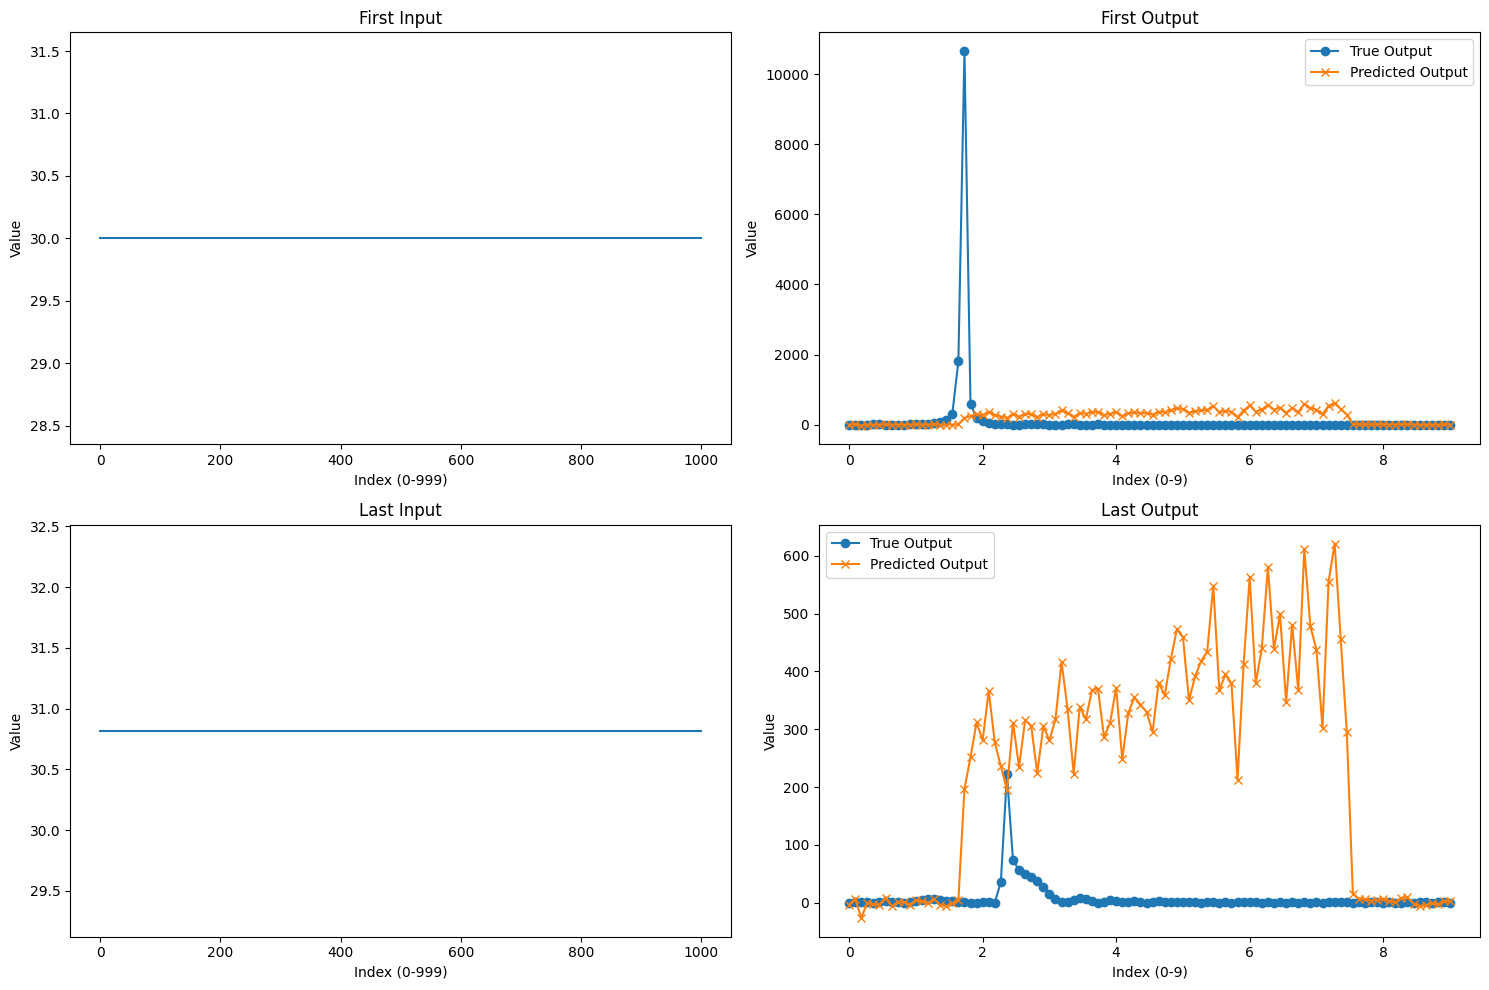

: 

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# 学習済みモデルを使用して予測を取得
batch = next(iter(ds))
inputs, outputs = batch

# state.apply_fnを使って予測を行う
# 注意: state.apply_fnの引数は (params, inputs) または (params, inputs, rng) の形式です。
# rngが必要な場合は、適切な乱数生成器を渡してください。
predictions = final_state.apply_fn(final_state.params, inputs)

# 最初と最後のデータポイントを取得
first_input = inputs[0]
first_output = outputs[0]
first_prediction = predictions[0]

last_input = inputs[-1]
last_output = outputs[-1]
last_prediction = predictions[-1]

# 横軸を作成
input_x = jnp.linspace(0, 999, 1000)
output_x = jnp.linspace(0, 9, 100)

# プロットを作成
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 最初のinputをプロット
axs[0, 0].plot(input_x, first_input)
axs[0, 0].set_title('First Input')
axs[0, 0].set_xlabel('Index (0-999)')
axs[0, 0].set_ylabel('Value')

# 最初のoutputと予測をプロット
axs[0, 1].plot(output_x, first_output, 'o-', label='True Output')
axs[0, 1].plot(output_x, first_prediction, 'x-', label='Predicted Output')
axs[0, 1].set_title('First Output')
axs[0, 1].set_xlabel('Index (0-9)')
axs[0, 1].set_ylabel('Value')
axs[0, 1].legend()

# 最後のinputをプロット
axs[1, 0].plot(input_x, last_input)
axs[1, 0].set_title('Last Input')
axs[1, 0].set_xlabel('Index (0-999)')
axs[1, 0].set_ylabel('Value')

# 最後のoutputと予測をプロット
axs[1, 1].plot(output_x, last_output, 'o-', label='True Output')
axs[1, 1].plot(output_x, last_prediction, 'x-', label='Predicted Output')
axs[1, 1].set_title('Last Output')
axs[1, 1].set_xlabel('Index (0-9)')
axs[1, 1].set_ylabel('Value')
axs[1, 1].legend()

plt.tight_layout()
plt.show()